In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import json
# json 파일이 있는 폴더의 경로
folder_path = "json"

actions = []

# 폴더 내의 모든 파일을 가져와서 처리합니다.
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)

    # JSON 파일인지 확인합니다.
    if os.path.isfile(file_path) and file_name.endswith('.json'):
        with open(file_path, 'r', encoding='utf-8') as json_file:
            data = json.load(json_file)
            name = data['data'][0]['attributes'][0]['name']
            actions.append(name)

print(actions)

['운전면허', '골키퍼', '구경', '성토', '권투']


In [10]:
data = np.concatenate([
     
     np.load('D:/캡스톤 연습/net_aihub_test/seq_운전면허_1697611268.npy'),
     np.load('D:/캡스톤 연습/net_aihub_test/seq_골키퍼_1697611268.npy'),
     np.load('D:/캡스톤 연습/net_aihub_test/seq_구경_1697611268.npy'),
     np.load('D:/캡스톤 연습/net_aihub_test/seq_성토_1697611268.npy'),
     np.load('D:/캡스톤 연습/net_aihub_test/seq_권투_1697611268.npy'),


], axis=0)

data.shape

(2325, 30, 104)

In [11]:
x_data = data[:,:, :-1] #라벨 값만 빼고 x_data로 만듦
labels = data[:,0,-1] #마지막 값이 라벨이므로 마지막 값만 라벨로 만듬

print(x_data.shape)
print(labels.shape)

(2325, 30, 103)
(2325,)


In [12]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2325, 5)

In [13]:
from sklearn.model_selection import train_test_split
# training set과 testset을 나눔

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2092, 30, 103) (2092, 5)
(233, 30, 103) (233, 5)


In [14]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                43008     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 45,253
Trainable params: 45,253
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    callbacks=[
        ModelCheckpoint('models/aihub_model2.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/100
64/66 [============================>.] - ETA: 0s - loss: 178.3805 - acc: 0.2456
Epoch 1: val_acc improved from -inf to 0.30901, saving model to models\aihub_model2.h5
66/66 [==============================] - 2s 18ms/step - loss: 177.1467 - acc: 0.2467 - val_loss: 158.8040 - val_acc: 0.3090 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 75.5441 - acc: 0.3886
Epoch 2: val_acc improved from 0.30901 to 0.38197, saving model to models\aihub_model2.h5
66/66 [==============================] - 1s 12ms/step - loss: 75.5441 - acc: 0.3886 - val_loss: 58.5003 - val_acc: 0.3820 - lr: 0.0010
Epoch 3/100
65/66 [============================>.] - ETA: 0s - loss: 87.3985 - acc: 0.4284
Epoch 3: val_acc improved from 0.38197 to 0.54936, saving model to models\aihub_model2.h5
66/66 [==============================] - 1s 12ms/step - loss: 87.0046 - acc: 0.4293 - val_loss: 25.0835 - val_acc: 0.5494 - lr: 0.0010
Epoch 4/100
66/66 [==============================] -

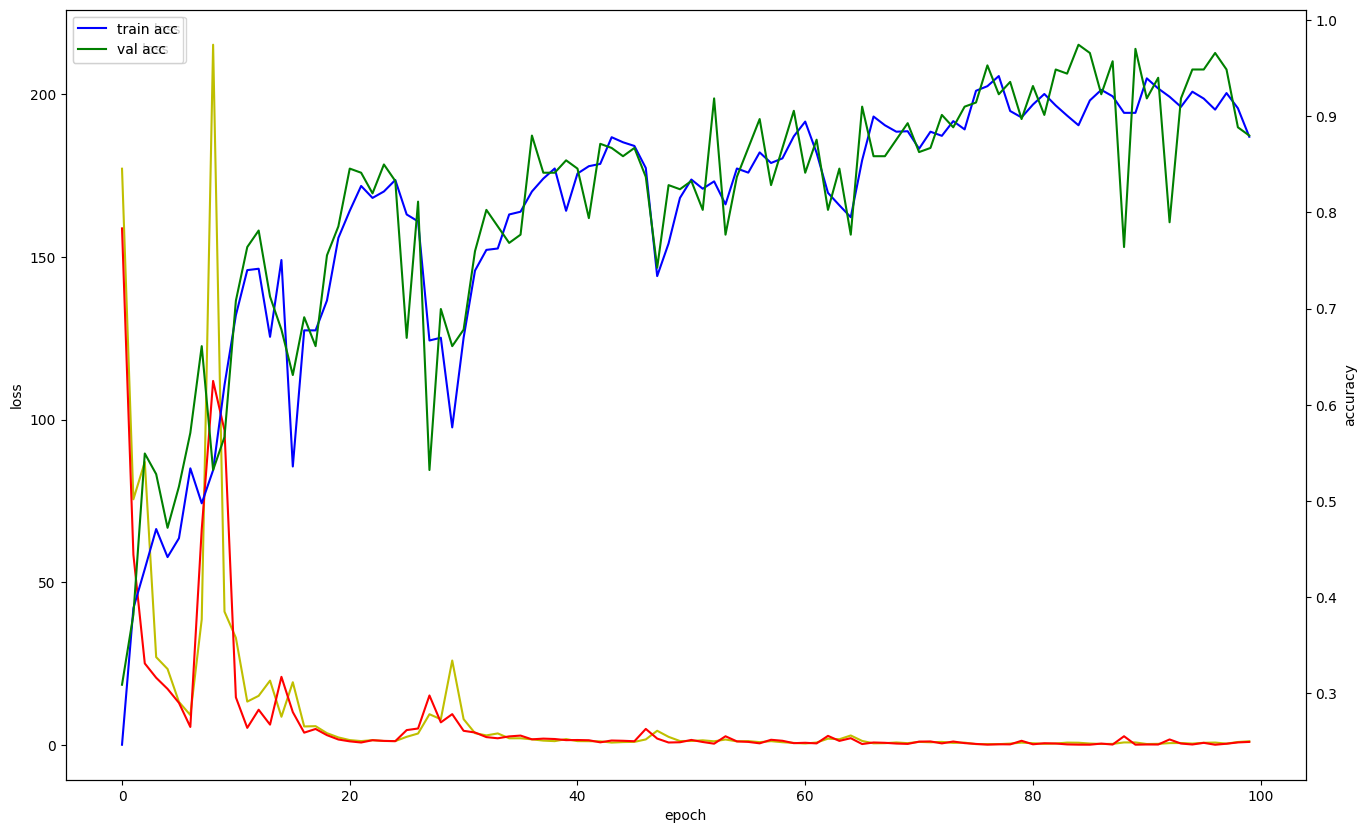

In [16]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()